# Задание 5. Извлечение данных 

## Задание 5.1

Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или аналогичных библиотек, постройте график числа сообщений в зависимости от даты. 

## Задание 5.2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательна визуализация. 

In [35]:
%%capture
!pip install telethon
!pip install nest-asyncio

In [1]:
from __future__ import annotations
import nest_asyncio
import asyncio
nest_asyncio.apply()
from telethon import TelegramClient, functions, types
from asyncio import run
import telethon
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
'''
# Функция для парсинга
async def get_channel_info(channel_name: str, api_id: int, api_hash: int,
                           parsed_last_time: datetime = None, limit: int = None):
    async with TelegramClient('session', api_id, api_hash) as client:
        channel = await client.get_entity(channel_name)
        reverse = True
        if not parsed_last_time:
            reverse = False
        messages = await client.get_messages(channel, offset_date=parsed_last_time, limit=limit, reverse=reverse)
        return (messages)

# Формирование dataframe с содержанием сообщения и датой
def preprocess_data_to_df(output: telethon.helpers.TotalList) -> pd.DataFrame:
    contents, dates = [], []
    for out_news in output:
        content = out_news.message
        if not content:
            continue
        date = out_news.date
        contents.append(content)
        dates.append(date)
        
    news_dataframe = pd.DataFrame({'content': contents, 'date': dates})
    news_dataframe['date'] = news_dataframe['date'].dt.normalize()
    return news_dataframe

#secrets
API_ID = 0
API_HASH = ''
date_format = '%Y-%m-%d'
channelName = 'Sputnik_results'

out = run(get_channel_info(channelName, API_ID, API_HASH, pd.to_datetime('2020-01-01')))
df = preprocess_data_to_df(out)
df.to_csv('Task5_data/telegram_data.csv', index = False, date_format = date_format)
'''

In [2]:
df = pd.read_csv('Task5_data/telegram_data.csv', parse_dates = ['date'])
df['year'] = df['date'].dt.year
df['mounth'] = df['date'].dt.month

In [16]:
# тесты для re пола и возраста
def test_re_match(sex_pattern):
    assert sex_pattern.fullmatch('М 39')[0] == 'М 39', f"{sex_pattern.fullmatch('М 39')}"
    assert sex_pattern.fullmatch('Ж45')[0] == 'Ж45', f"{sex_pattern.fullmatch('Ж45')}"
    assert sex_pattern.fullmatch('женщина34')[0] == 'женщина34', f"{sex_pattern.fullmatch('женщина34')}"
    assert sex_pattern.fullmatch('мужчина9')[0] == 'мужчина9', f"{sex_pattern.fullmatch('мужчина9')}"
    assert sex_pattern.fullmatch('М,57')[0] == 'М,57', f"{sex_pattern.fullmatch('М,57')}"
    assert sex_pattern.fullmatch('Ж, 22')[0] == 'Ж, 22', f"{sex_pattern.fullmatch('Ж, 22')}"
    assert sex_pattern.fullmatch('М. 30')[0] == 'М. 30', f"{sex_pattern.fullmatch('М. 30')}"
    assert sex_pattern.fullmatch('муха') is None, f"{sex_pattern.fullmatch('муха')}"
    assert sex_pattern.fullmatch('монитор 45') is None, f"{sex_pattern.fullmatch('монитор 45')}"

    
def test_re_find(sex_pattern):
    number_re = re.compile(r"\d{1,2}")
    res = sex_pattern.findall('М 39')[0]
    assert res[0] == 'М' and number_re.findall(res[1])[0] == '39'
    res = sex_pattern.findall('Ж45')[0]
    assert res[0] == 'Ж' and number_re.findall(res[1])[0] == '45'
    res = sex_pattern.findall('женщина34')[0]
    assert res[0] == 'женщина' and number_re.findall(res[1])[0] == '34'
    res = sex_pattern.findall('мужчина9')[0]
    assert res[0] == 'мужчина' and number_re.findall(res[1])[0] == '9'
    res = sex_pattern.findall('мужчина 20')[0]
    assert res[0] == 'мужчина' and number_re.findall(res[1])[0] == '20'
    
    res = sex_pattern.findall('М,57')[0]
    assert res[0] == 'М' and number_re.findall(res[1])[0] == '57'
    res = sex_pattern.findall('Ж, 22')[0]
    assert res[0] == 'Ж' and number_re.findall(res[1])[0] == '22'
    res = sex_pattern.findall('М. 30')[0]
    assert res[0] == 'М' and number_re.findall(res[1])[0] == '30'
    
def test_re(sex_pattern):
    test_re_match(sex_pattern)
    test_re_find(sex_pattern)


sex_age_pattern = re.compile(r"((?:\b[ЖжмМ](?:(?:[ужченщ]+?ина)))|(?:\b[ЖжмМ]{1}))([\.?,?\s?]*\d{1,2}\b)")
test_re(sex_age_pattern)    

In [4]:
# поиск паттернов в сообщении
df['reg'] = df['content'].apply(lambda x: sex_age_pattern.findall(x))
# отбор сообщений с одним упоминанием пола и ввозраста 
df = df[df['reg'].apply(lambda x: len(x)==1)]

# создание столбцов с информацией о поле и возрасте
df['sex'] = df['reg'].apply(lambda x: x[0][0].lower()[0])
number_re = re.compile(r"\d{1,2}")
df['age'] = df['reg'].apply(lambda x: int(number_re.findall(x[0][1])[0]))

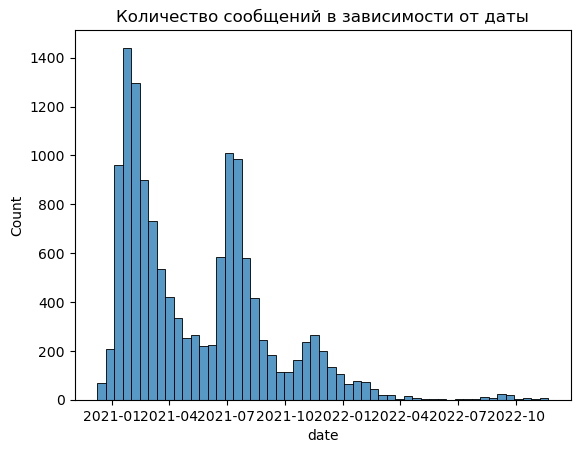

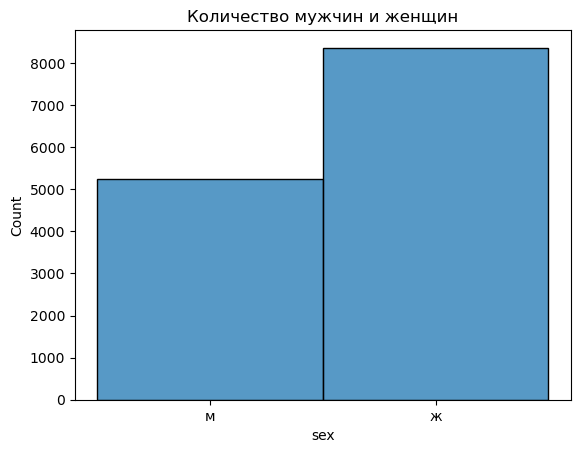

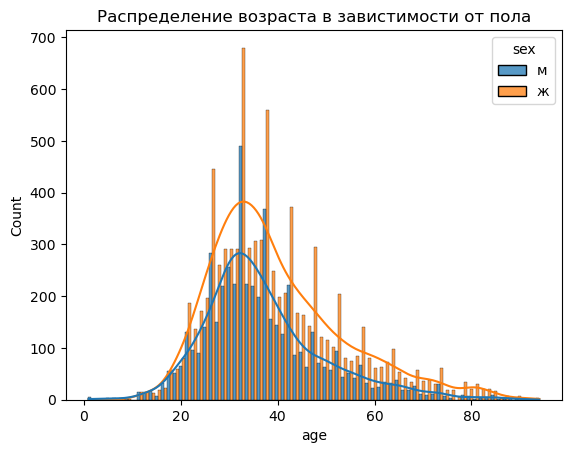

In [14]:
sns.histplot(df['date'])
plt.title('Количество сообщений в зависимости от даты')
plt.show()

sns.histplot(df['sex'])
plt.title('Количество мужчин и женщин')
plt.show()

sns.histplot(data = df, x='age', hue = 'sex', kde=True, multiple="dodge", alpha = 0.75)
plt.title('Распределение возраста в завистимости от пола')
plt.show()

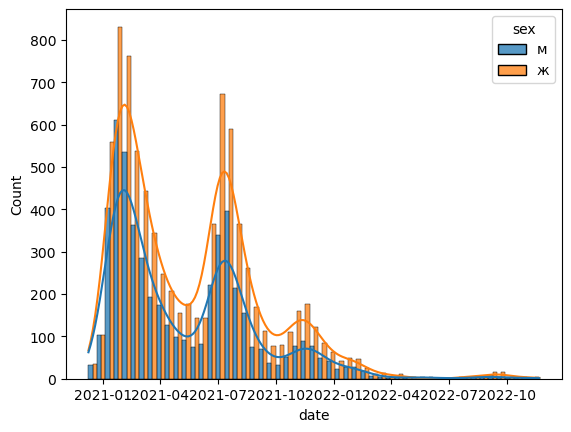

In [9]:
sns.histplot(data = df, x = 'date', hue='sex', kde=True, multiple="dodge", alpha = 0.75)
plt.show()

In [15]:
sputnik_re = re.compile(r"[сС]путник")
df['sputnik_vac'] = df['content'].apply(lambda x: len(sputnik_re.findall(x)) > 0)
revac_re = re.compile(r"(?:ревакцинация)|(?:#ревак )")
df['revac_status'] = df['content'].apply(lambda x: len(revac_re.findall(x)) > 0 )
bau_re = re.compile('BAU/ml')
df[df['content'].apply(lambda x: len(bau_re.findall(x)) > 0)]

,content,date,year,mounth,reg,sex,age,sputnik_vac,revac_status
12713,"М47, эзофагит, хр. гастрит, повышенное АД, изб...",2021-05-25,2021,5,"[(М, 47)]",м,47,False,False
16783,"Ж42 -хронических нет, ковидом болела бессимпто...",2021-07-16,2021,7,"[(Ж, 42)]",ж,42,True,False
17341,Отчет пишу за мужа. \nМ 40 лет. Букет хрони: О...,2021-07-21,2021,7,"[(М, 40)]",м,40,True,False
17629,"Ж41, 1 +, особой хрони нет\nБолела в ноябре в ...",2021-07-24,2021,7,"[(Ж, 41)]",ж,41,True,False
17797,"Ж 34, ДЖВП, гемангиома печени, ангиолипома поч...",2021-07-26,2021,7,"[(Ж, 34)]",ж,34,True,False
...,...,...,...,...,...,...,...,...,...
23027,#мбквк #москва м38\n#спутник #ревак\nV1 02.02....,2022-02-22,2022,2,"[(м, 38)]",м,38,True,False
23073,М12 КИ спутник-м #дети\n\n12.11.2021 V1 без не...,2022-03-06,2022,3,"[(М, 12)]",м,12,True,False
23101,"М 90 (в анамнезе онкология, мерцательная аритм...",2022-03-14,2022,3,"[(М, 90)]",м,90,True,False
23330,#ревак #назально Ж41 Москва\n30.09.22 ревак на...,2022-10-10,2022,10,"[(Ж, 41)]",ж,41,True,True
